## SHAP tutorial for an explainable binary classification model
### Hongyi Duan (hd162)
Goal: demonstrate end-to-end SHAP usage on a tabular dataset, including global explanations (summary beeswarm, bar, dependence with interaction) and local explanations (force and decision plots). The entire notebook is self-contained and reproducible.

In [18]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["figure.dpi"] = 400
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 11

Dataset and task: use the sklearn Wisconsin Diagnostic Breast Cancer dataset. Target is malignant vs benign. We will do minimal preprocessing to keep the focus on interpretability.

In [19]:
ds = load_breast_cancer()
X = pd.DataFrame(ds.data, columns=ds.feature_names)
y = pd.Series(ds.target, name="target") 

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full
)

print("Shapes (train, val, test):", X_train.shape, X_val.shape, X_test.shape)

Shapes (train, val, test): (341, 30) (114, 30) (114, 30)


Train a simple baseline model. We choose RandomForestClassifier because it performs well on tabular data and is natively supported by SHAP TreeExplainer.

In [20]:
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

def evaluate(model, X_split, y_split, name):
    proba = model.predict_proba(X_split)[:, 1]
    pred = (proba >= 0.5).astype(int)
    print(f"[{name}] AUC = {roc_auc_score(y_split, proba):.4f}")
    print(f"[{name}] Classification report:\n{classification_report(y_split, pred)}")

evaluate(rf, X_val, y_val, "val")
evaluate(rf, X_test, y_test, "test")

[val] AUC = 0.9812
[val] Classification report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        43
           1       0.96      0.97      0.97        71

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

[test] AUC = 0.9907
[test] Classification report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        42
           1       0.96      0.96      0.96        72

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



Build the SHAP explainer. For tree-based models, use TreeExplainer. We compute SHAP values for the positive class (benign = 1 in this dataset). For stable global statistics, we explain the validation split.

In [21]:
explainer = shap.TreeExplainer(rf, data=X_train)

shap_val = explainer(X_val)

if 1 in list(rf.classes_):
    class_index = int(np.where(rf.classes_ == 1)[0][0])
else:
    class_index = -1

vals = shap_val.values
if vals.ndim == 3:
    vals = vals[:, :, class_index]

bases = shap_val.base_values
if bases.ndim == 2:
    bases = bases[:, class_index]

print("vals shape:", vals.shape)    
print("X_val shape:", X_val.shape)

vals shape: (114, 30)
X_val shape: (114, 30)


**Global explanation 1: summary beeswarm**
<br>
This shows feature importance ordering and how feature values (color) push predictions positively or negatively (x-axis).

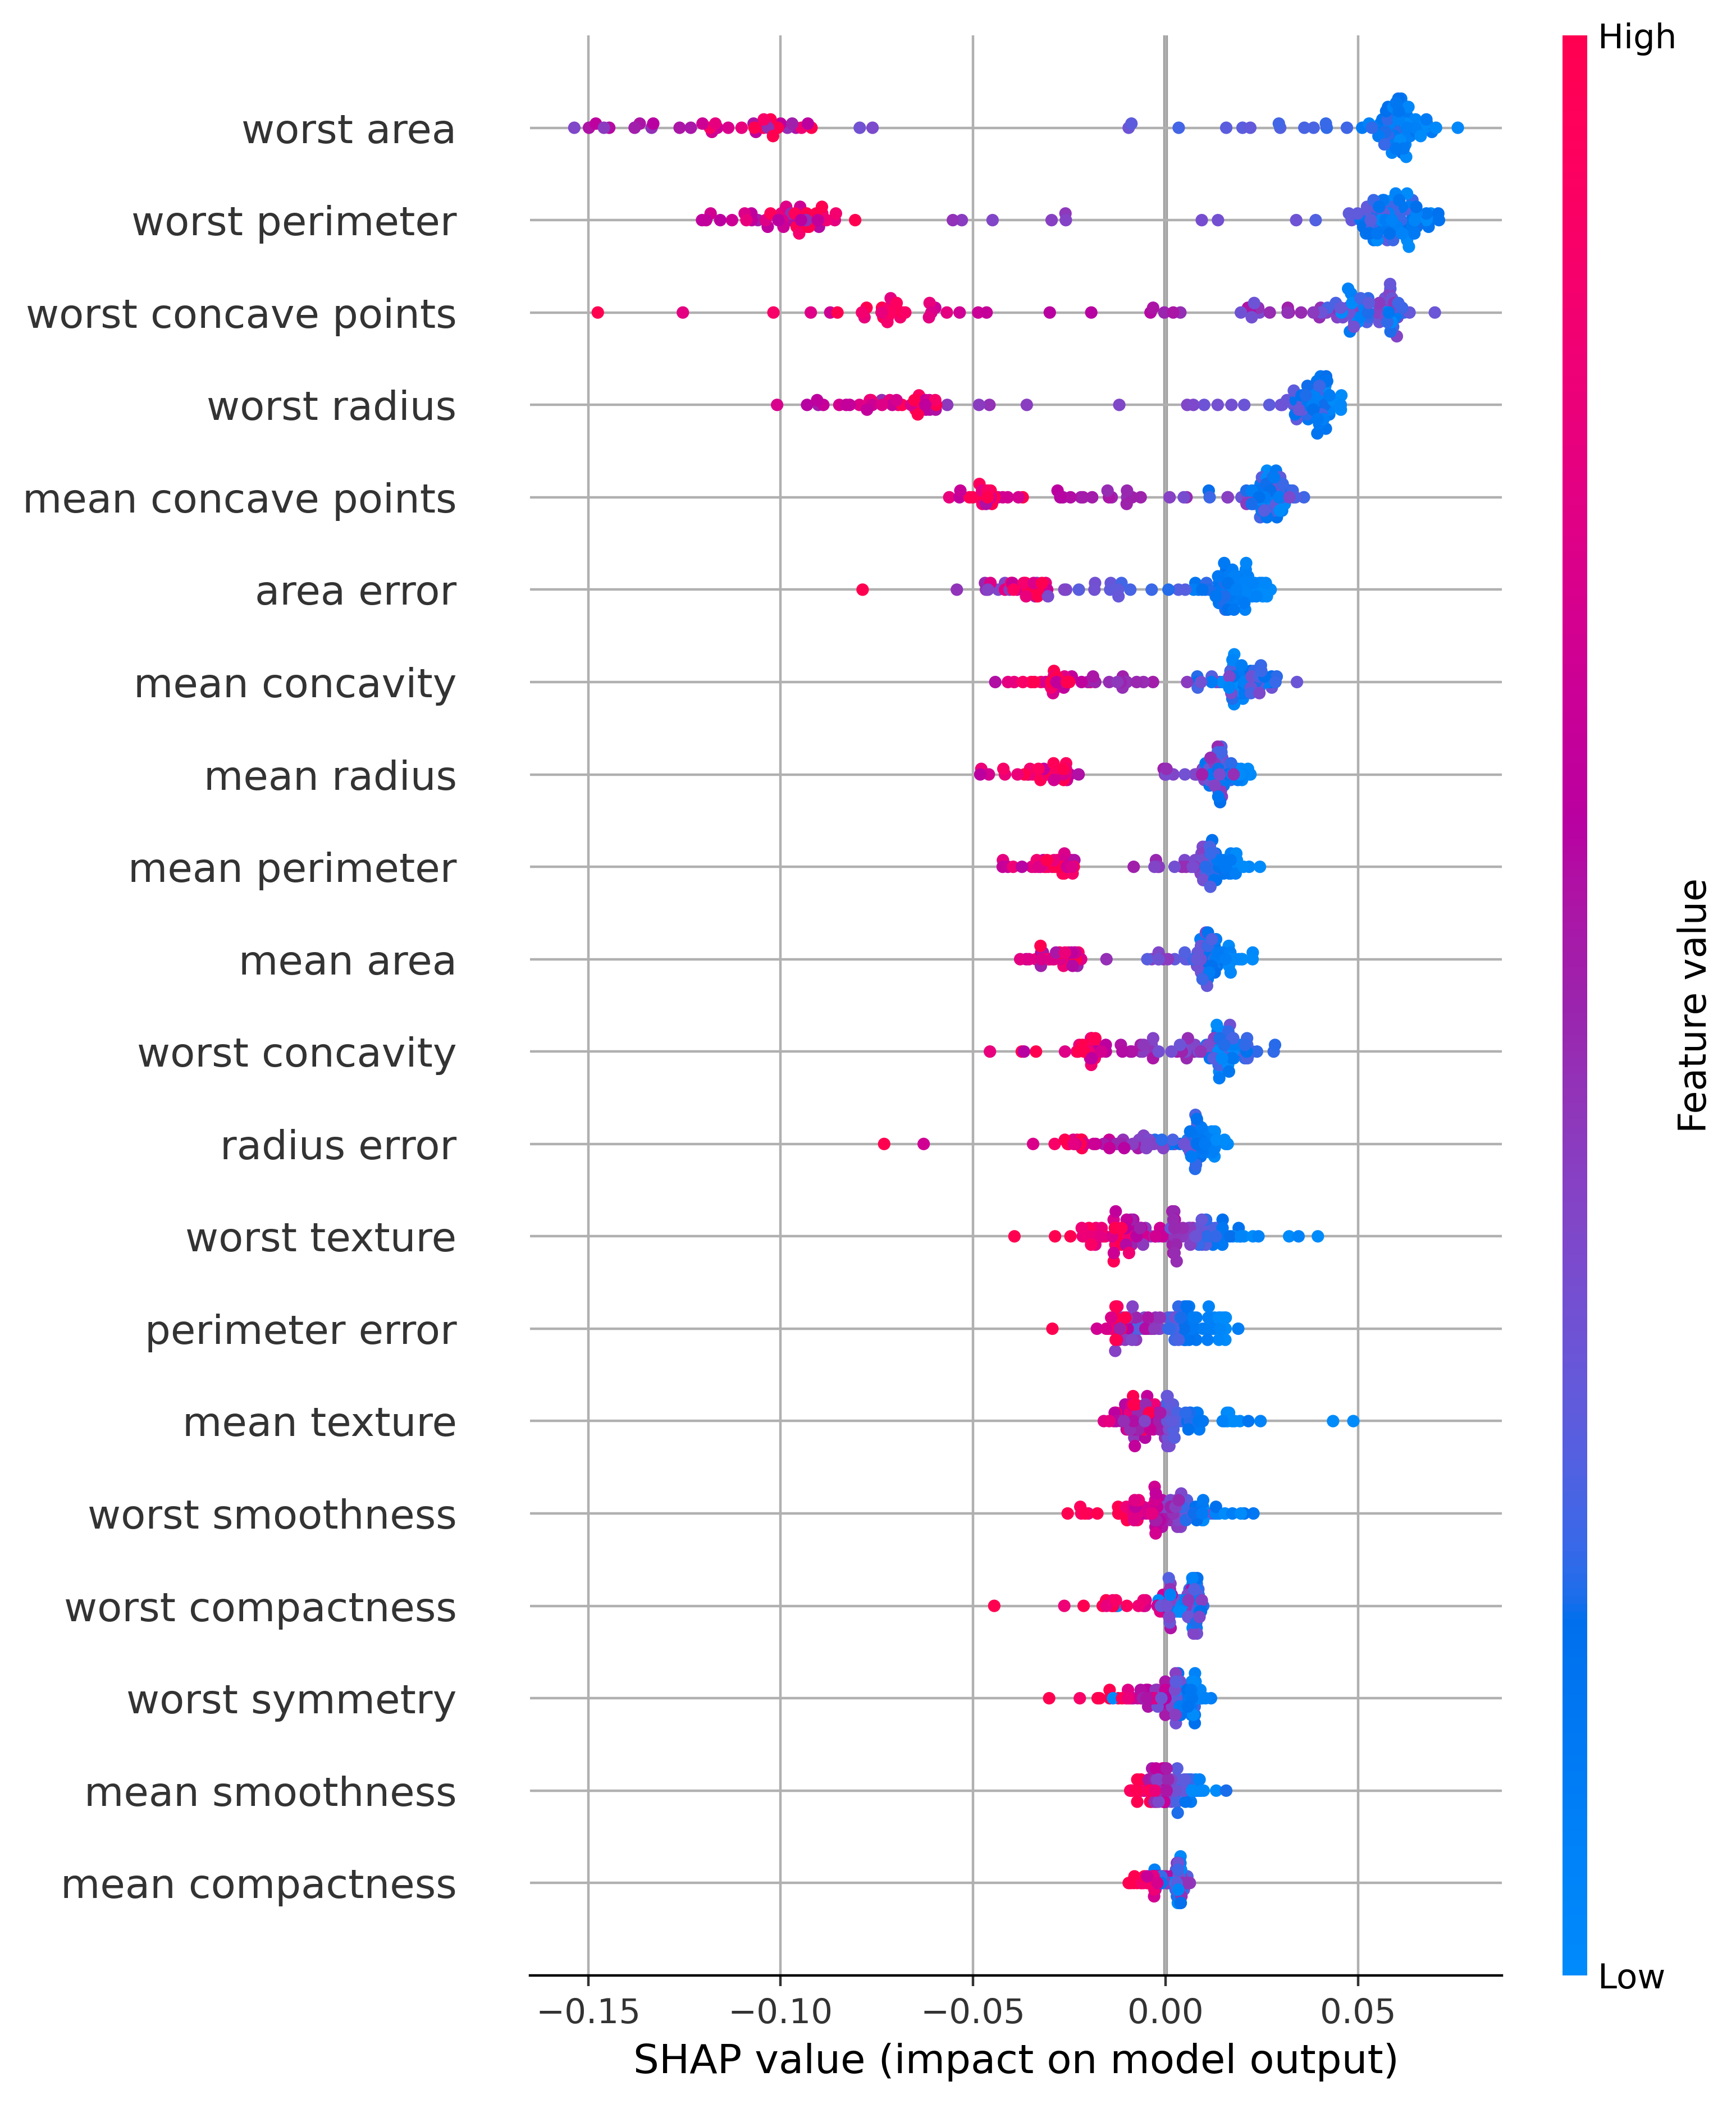

In [22]:
shap.summary_plot(vals, X_val, plot_type="dot", show=True)

The beeswarm plot shows both the global importance of each feature and how their values influence predictions. Features such as worst area, worst perimeter, and worst concave points are the top contributors to the model output. The color gradient indicates the feature value: red represents high feature values and blue represents low ones. High values of these top features tend to push the prediction toward benign (positive SHAP values), while lower values push toward malignant (negative SHAP values). The plot reveals that tumor size–related features play a dominant role in determining model predictions.

<br>

**Global explanation 2: bar plot of mean absolute SHAP**
<br>
This is a compact ranking suitable for reports.

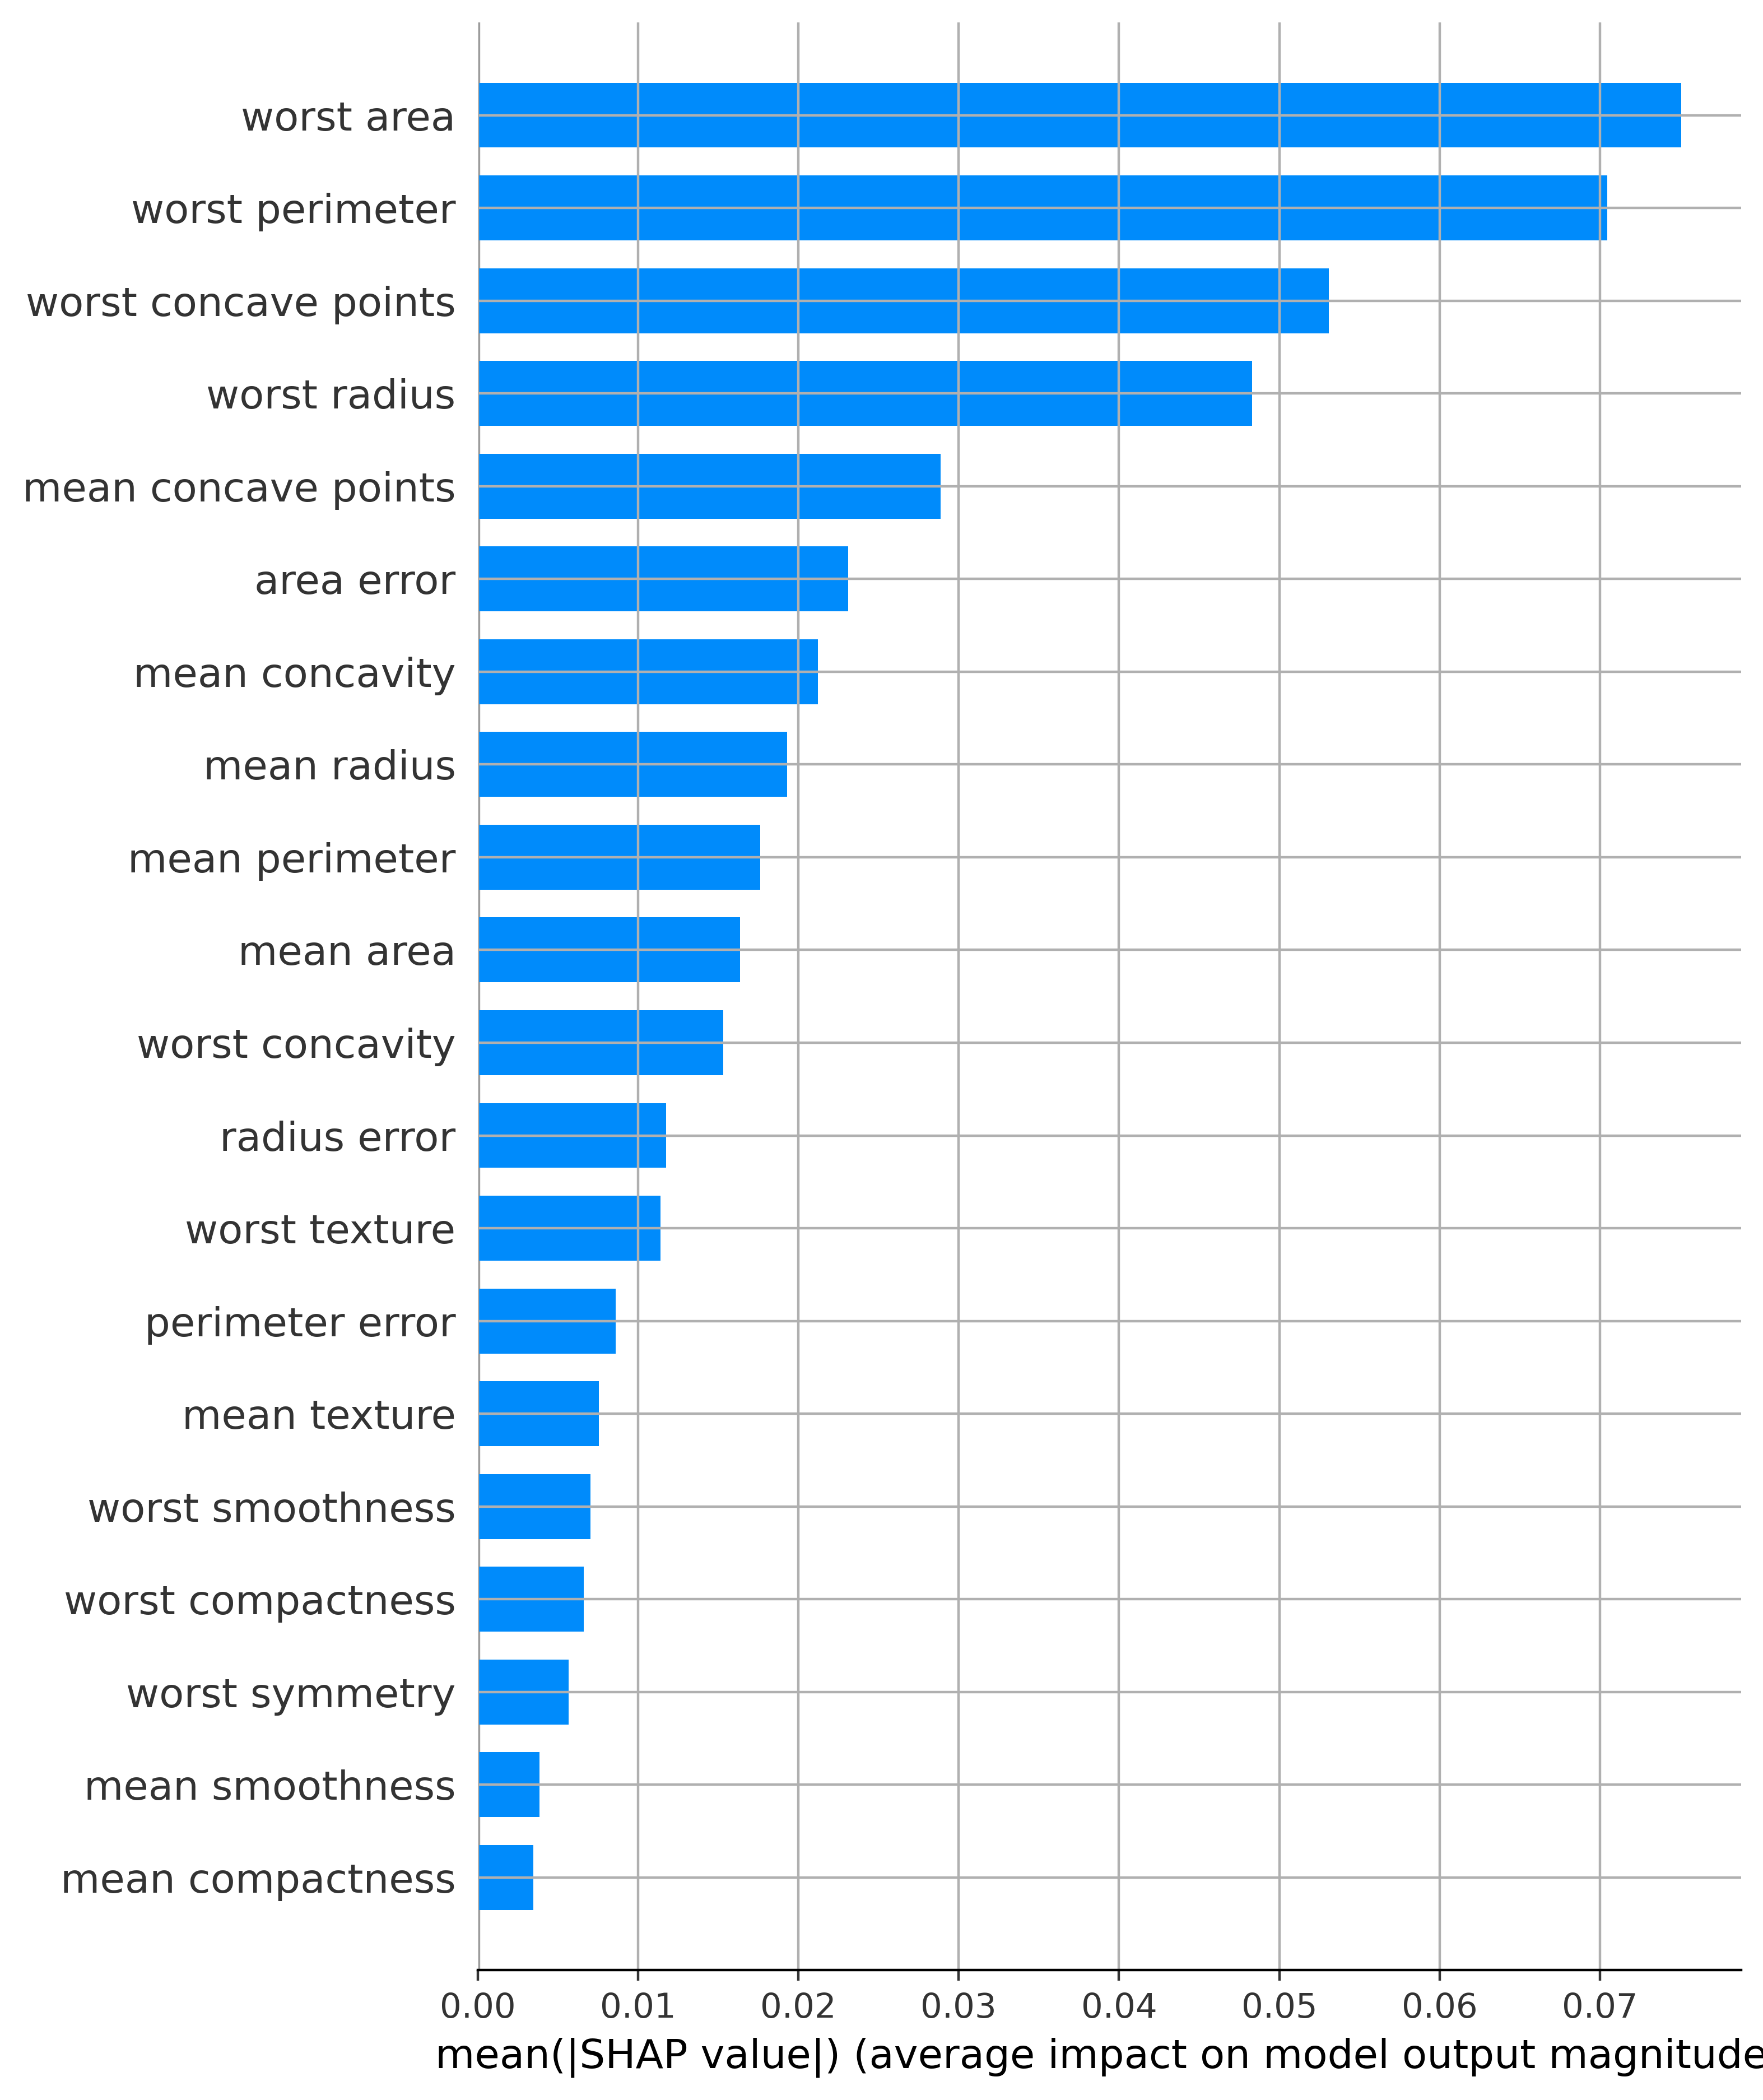

In [23]:
shap.summary_plot(vals, X_val, plot_type="bar", show=True)

The bar plot ranks features by their average absolute SHAP values, providing a clearer measure of global importance. Worst area and worst perimeter stand out as the most influential variables, followed by worst concave points and worst radius. This ranking aligns with the beeswarm plot, confirming that tumor boundary and size–related features are the primary drivers of classification decisions. The lower-ranked features, such as mean compactness and mean smoothness, contribute little to the model’s predictive power.

<br>

**Global explanation 3: dependence plot with interaction**
<br>
We select the top two features by mean absolute SHAP to ensure valid, data-driven choices.

Chosen for dependence plot: worst area (interaction: worst perimeter )


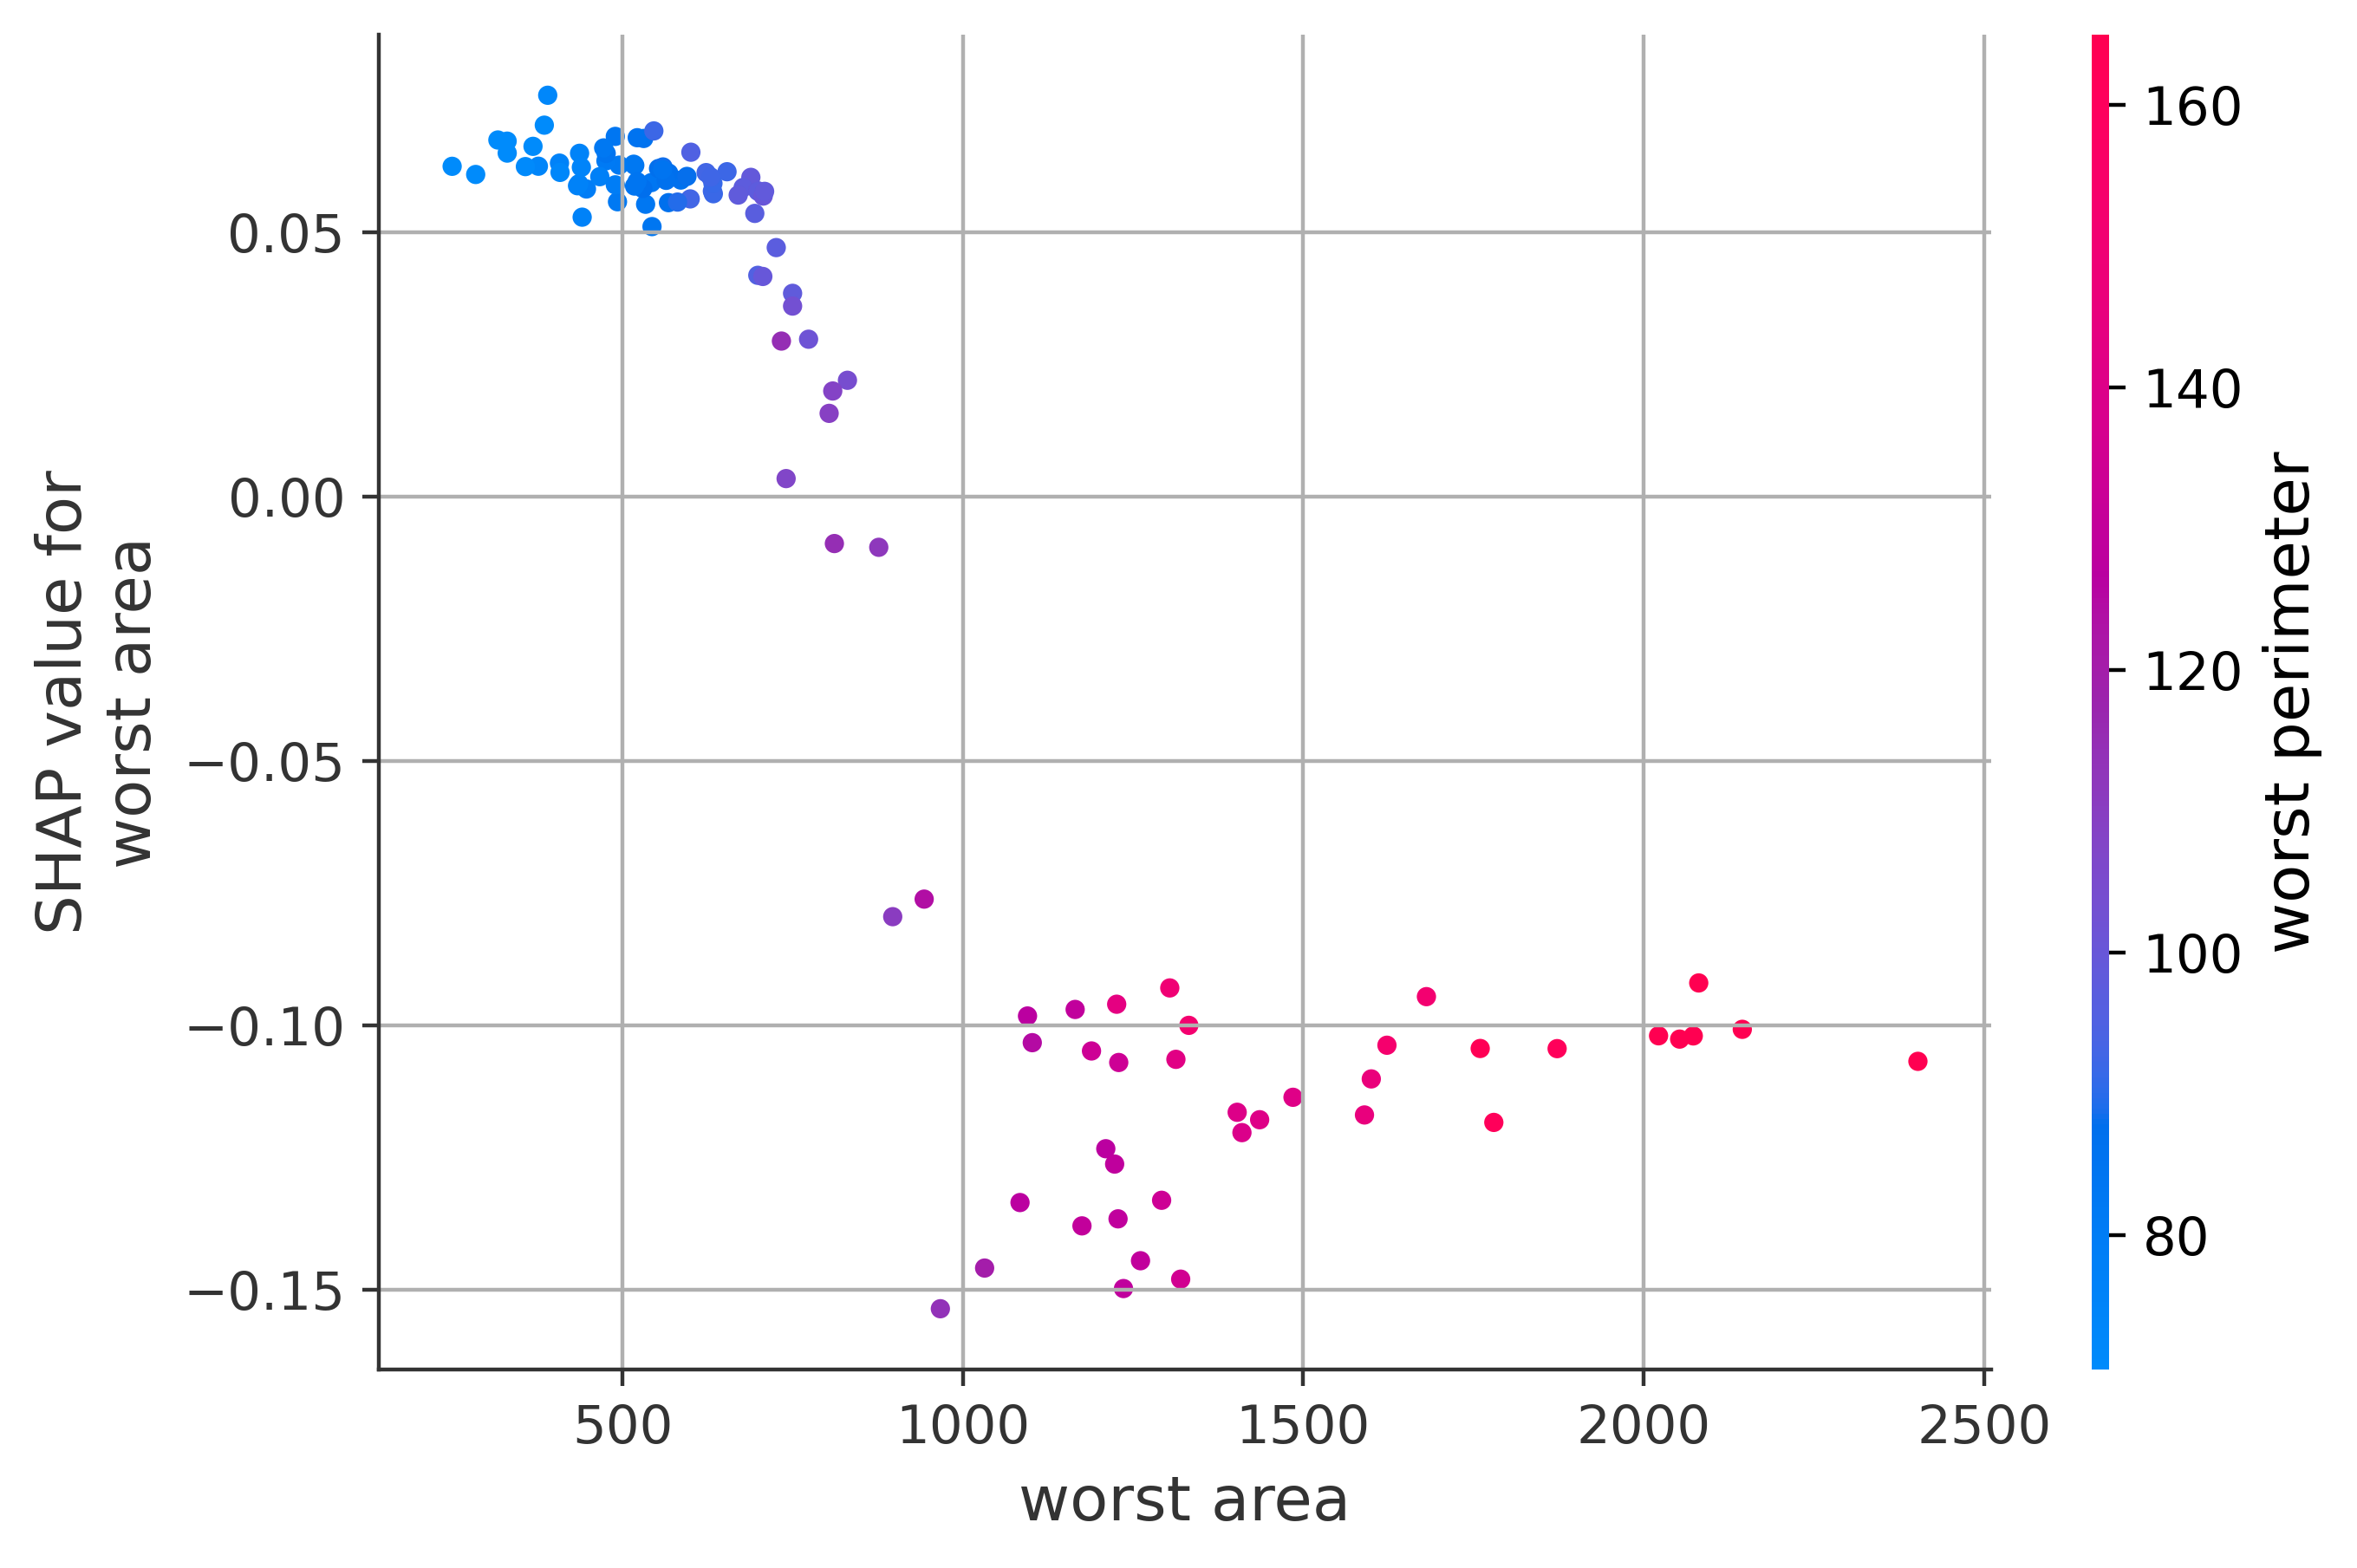

In [24]:
mean_abs = np.mean(np.abs(vals), axis=0)
order = np.argsort(mean_abs)[::-1]
main_feature = X_val.columns[order[0]]
interaction_feature = X_val.columns[order[1]] if len(order) > 1 else X_val.columns[0]

print("Chosen for dependence plot:", main_feature, "(interaction:", interaction_feature, ")")

shap.dependence_plot(
    main_feature,
    vals,
    X_val,
    interaction_index=interaction_feature,
    show=True
)

The dependence plot displays the relationship between a single feature (worst area) and its SHAP value, colored by another feature (worst perimeter). As worst area increases, the SHAP value decreases significantly, indicating that large tumor areas strongly reduce the predicted probability of being benign. The color gradient of worst perimeter shows a correlated pattern—samples with both large area and large perimeter push predictions toward malignant outcomes. The two features interact closely, illustrating that SHAP successfully captures feature interdependence.

<br>

**Local explanation: decision plot across multiple samples**
<br>
This shows cumulative contribution paths for a group of instances. We use a scalar baseline for a clean plot.

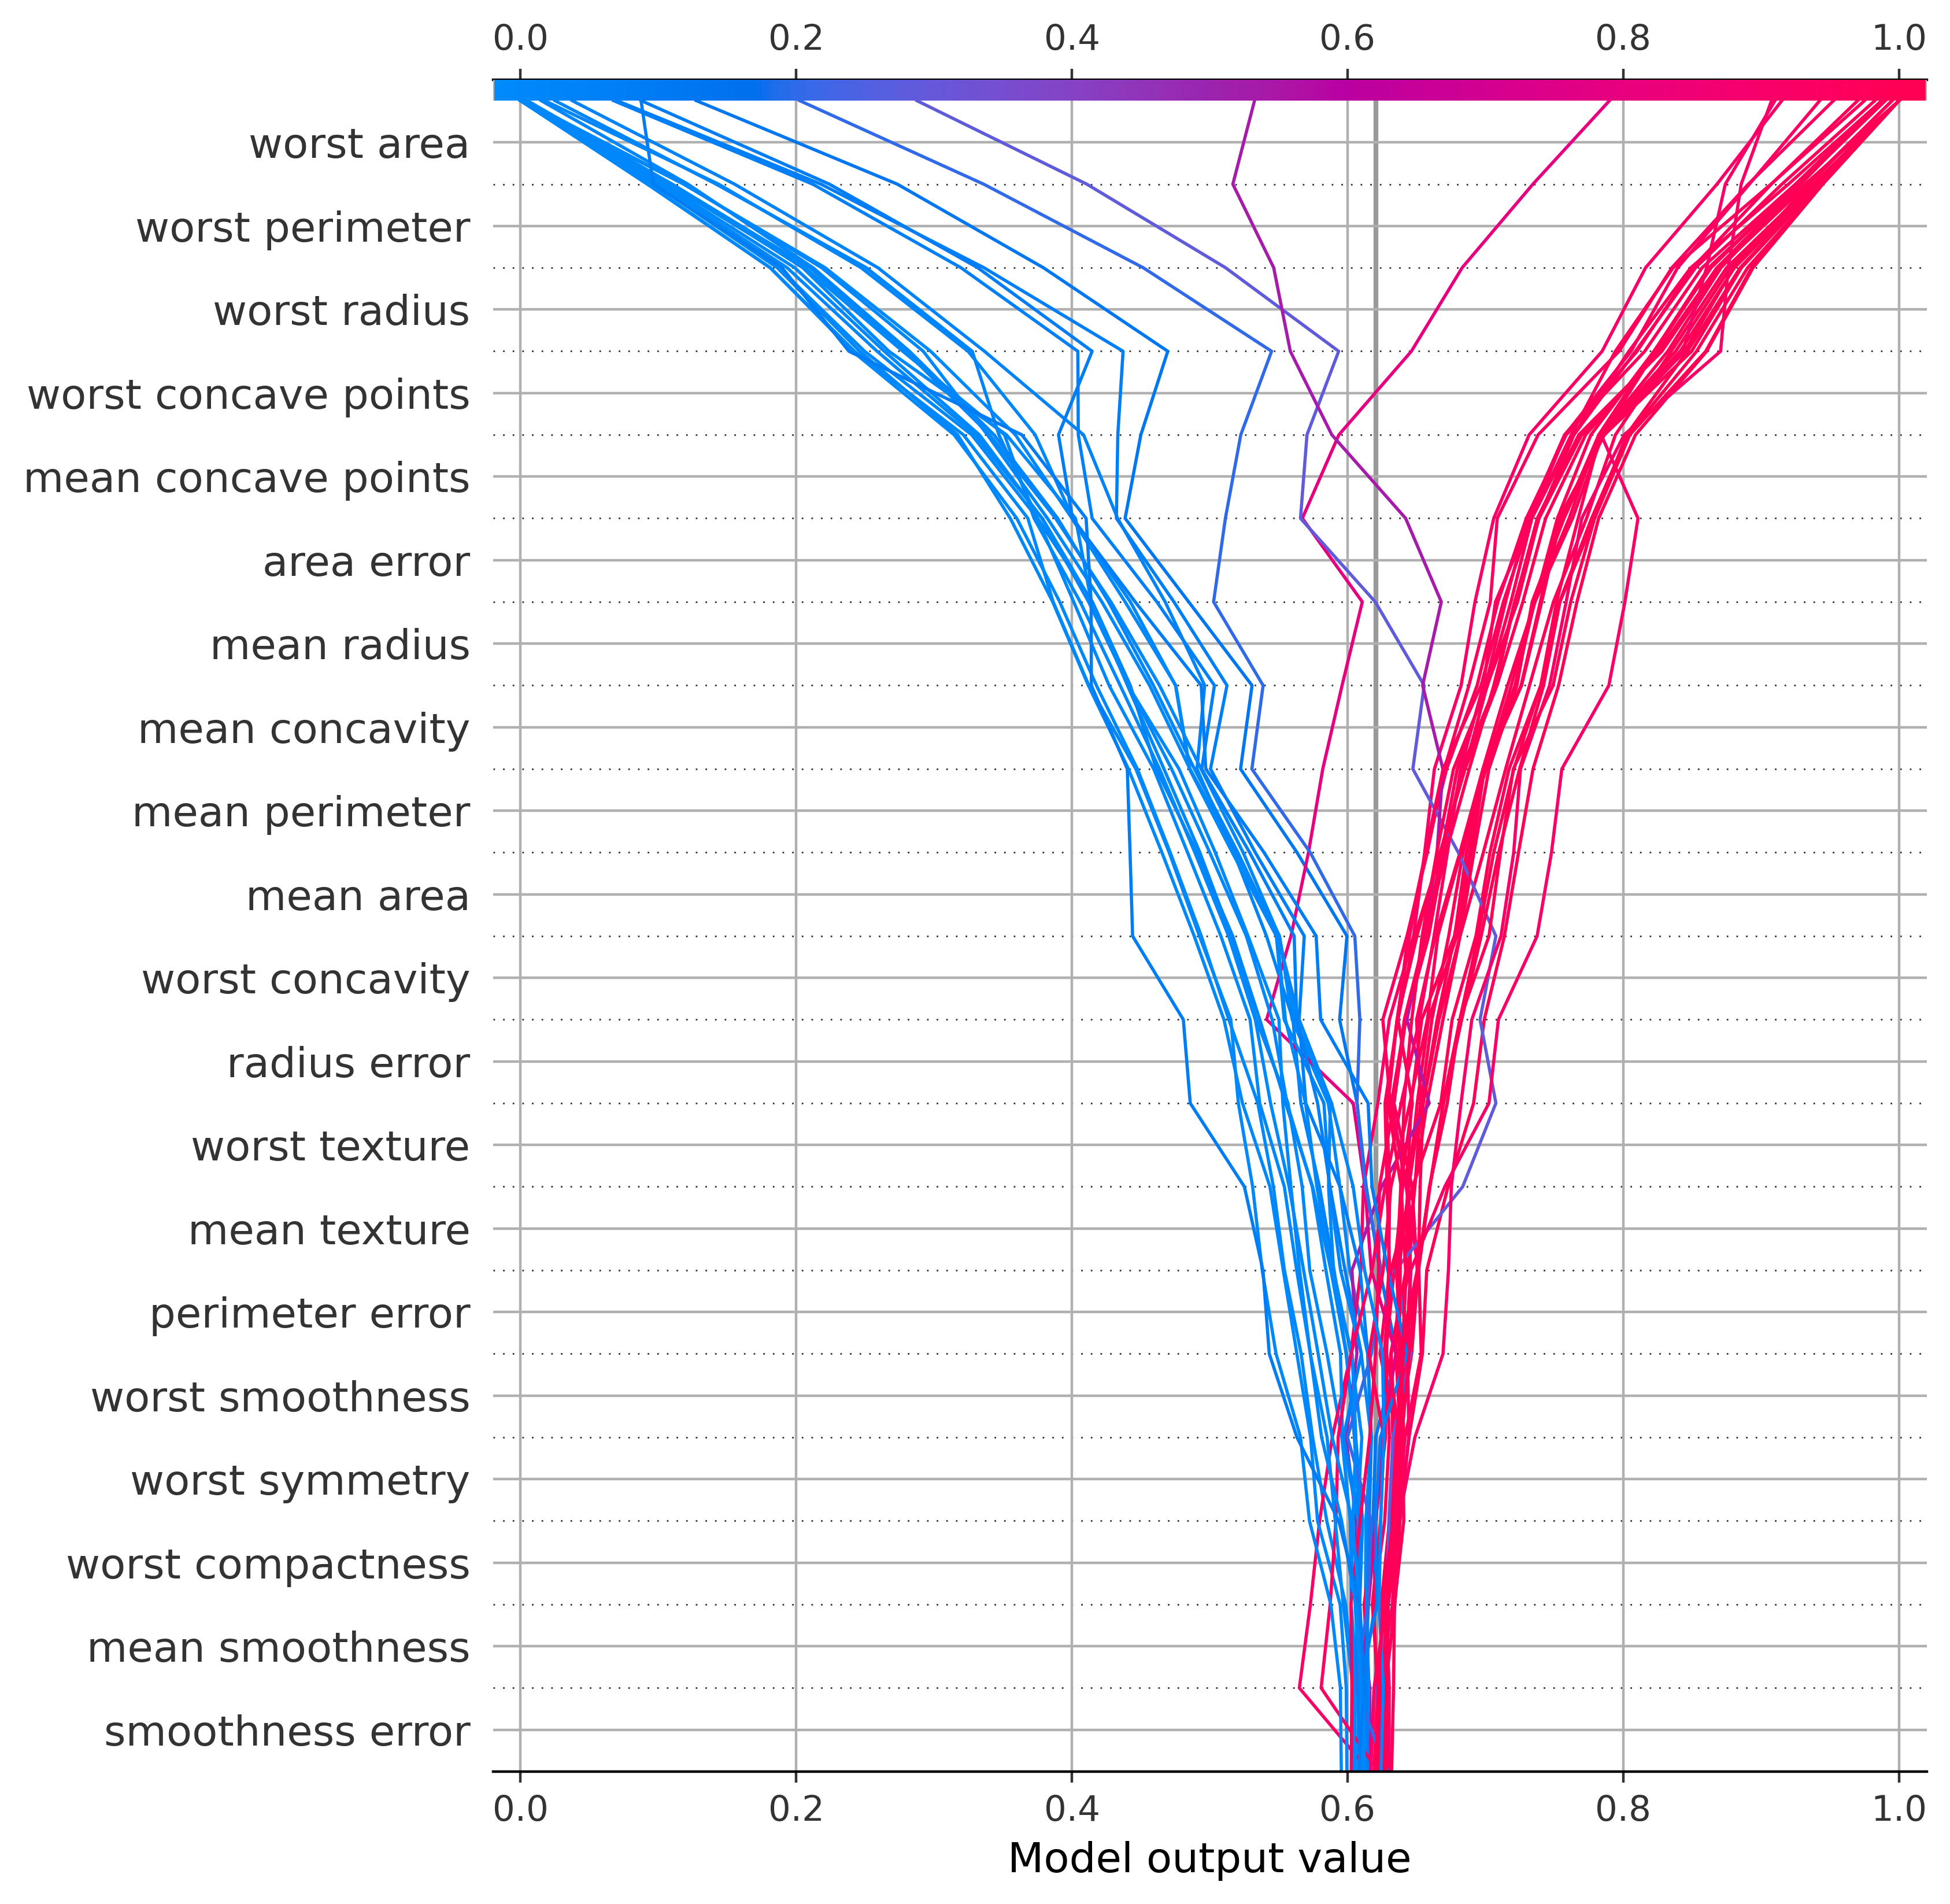

In [26]:
N = min(50, len(X_val))
idx = np.arange(N)

base_scalar = float(np.mean(bases))  # scalar baseline

shap.decision_plot(
    base_scalar,
    vals[idx, :],
    feature_names=list(X_val.columns),
    link="identity"
)

The decision plot visualizes the cumulative contribution of each feature to the model’s output across multiple validation samples. Lines starting near the baseline and ending near 1.0 represent samples predicted as benign, while those ending near 0.0 correspond to malignant cases. Features such as worst area and worst perimeter create the largest shifts in prediction, demonstrating their dominant impact. The dense clustering of trajectories around these key features shows that the model’s decision boundaries are largely shaped by tumor size and shape characteristics.

<br>

### Limitations and reflection
SHAP explains how each feature contributed to a specific prediction under the training data distribution, but it does not prove causal relationships. The importance rankings may vary across different random seeds or model types. Also, for tree models, SHAP values are computed on the log-odds scale and must be interpreted accordingly. Despite these limits, SHAP provides valuable insights for debugging, feature monitoring, and communicating model reasoning to non-technical audiences.

### Summary
This notebook presented an end-to-end SHAP workflow: training a RandomForest classifier, evaluating its performance, generating global and local explanations, and interpreting them in plain language. SHAP proved effective for understanding how tumor size and shape features influence classification. The step-by-step structure, visuals, and commentary together meet the goals of a clear, reproducible explainability tutorial.